In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
!git clone https://github.com/kymatio/kymatio.git

# go to kymatio folder
%cd kymatio

# use git to download the source
!git pull origin master

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

Cloning into 'kymatio'...
remote: Enumerating objects: 6149, done.
remote: Counting objects: 100% (909/909), done.
remote: Compressing objects: 100% (554/554), done.
remote: Total 6149 (delta 585), reused 584 (delta 346), pack-reused 5240
Receiving objects: 100% (6149/6149), 2.47 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (4024/4024), done.
/content/kymatio
From https://github.com/kymatio/kymatio
 * branch            master     -> FETCH_HEAD
Already up to date.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


running install
running bdist_egg
running egg_info
creating kymatio.egg-info
writing kymatio.egg-info/PKG-INFO
writing dependency_links to kymatio.egg-info/dependency_links.txt
writing requirements to kymatio.egg-info/requires.txt
writing top-level names to kymatio.egg-info/top_level.txt
writing manifest file 'kymatio.egg-info/SOURCES.txt'
adding license file 'LICENSE.md'
adding license file 'AUTHORS.md'
writing manifest file 'kymatio.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/kymatio
copying kymatio/torch.py -> build/lib/kymatio
copying kymatio/version.py -> build/lib/kymatio
copying kymatio/__init__.py -> build/lib/kymatio
copying kymatio/caching.py -> build/lib/kymatio
copying kymatio/sklearn.py -> build/lib/kymatio
copying kymatio/tensorflow.py -> build/lib/kymatio
copying kymatio/keras.py -> build/lib/kymatio
copying kymatio/jax.py -> build/lib/kymatio
copyi

In [ ]:
from colorsys import hls_to_rgb
import numpy as _np
import kymatio
from kymatio.scattering2d.filter_bank import filter_bank
from kymatio.torch import Scattering2D
from scipy.fft import fft2

import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
from scipy.signal import decimate

## Define image size

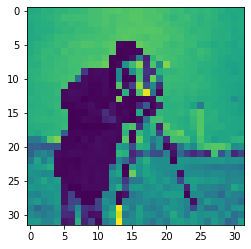

In [ ]:
size = 32
device = 'cuda'
image = plt.imread('/content/drive/My Drive/Impulse Hackathon/1.png')
image = torch.from_numpy(image)
image = torch.nn.functional.conv2d(image.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=int(256/size)).squeeze(0).squeeze(0)
plt.imshow(image)

## Plot Gabor filters

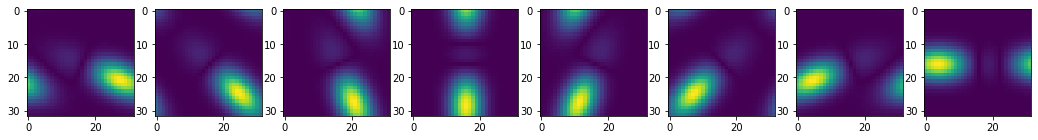

In [ ]:
M = size
J = 1
L = 8
filters_set = filter_bank(M, M, J, L=L)

fig, axs = plt.subplots(J, L)
fig.set_figheight(4)
fig.set_figwidth(18)
i = 0
for filter in list(filters_set['psi']):
    f = torch.from_numpy(filter["levels"][0])
    axs[i%L].imshow(torch.fft.fftshift(abs(f)))
    i = i+1
fig.show()

## Outputs for Gabor filter

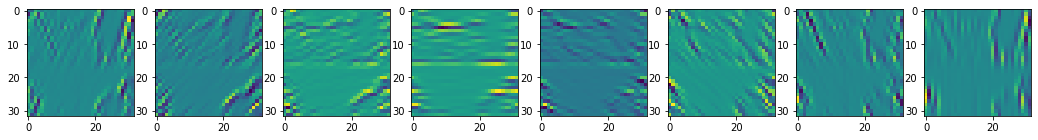

In [ ]:
fig, axs = plt.subplots(J, L)
fig.set_figheight(4)
fig.set_figwidth(18)
i = 0
for filter in list(filters_set['psi']):
    f = torch.from_numpy(filter["levels"][0])
    output = torch.real(torch.fft.ifft2(torch.fft.fft2(image)*f))
    axs[i%L].imshow(torch.fft.fftshift(output))
    i = i+1
fig.show()

## Construct and Plot 1-D filters

In [ ]:
def lp2(Nf, wp, ws):
    N = Nf // 2
    omega = torch.pi * torch.arange(1, N+1) / (N)
    fft_filt = torch.zeros((N, ))
    for i in range(N):
        if torch.abs(omega[i]) <= wp:
            fft_filt[i] = 1
        elif torch.abs(omega[i]) < ws:
            fft_filt[i] = 0.5 * (1 + torch.cos( (torch.abs(omega[i]) - wp) * torch.pi / (ws - wp) ))
        else:
            fft_filt[i] = 0
    #return torch.fft.fft(torch.fft.irfft(fft_filt, Nf))
    return torch.concat((fft_filt, torch.flip(fft_filt, dims=[0])))

def hp2(N, wp, ws):
    lpf = lp2(N, wp, ws)
    hpf = 1 - lpf
    return hpf

Text(0.5, 1.0, 'Highpass')

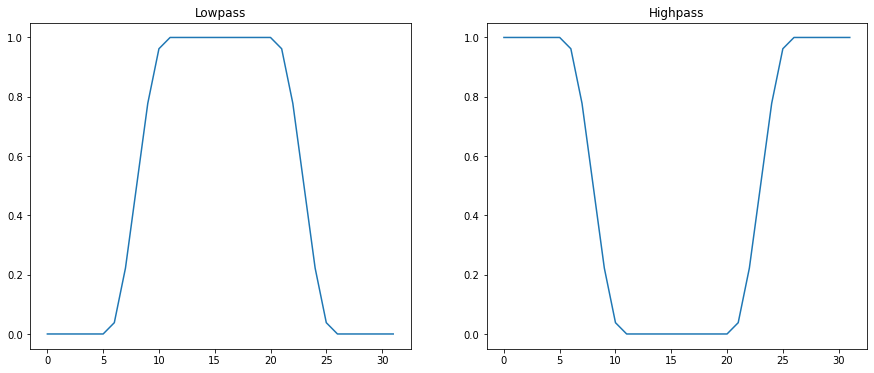

In [ ]:
plt.figure(figsize = (15,6))
plt.subplot(121)
plt.plot(torch.fft.fftshift(torch.real(lp2(size,torch.pi/3,2*torch.pi/3))))
plt.title('Lowpass')
plt.subplot(122)
plt.plot(torch.fft.fftshift(torch.real(hp2(size,torch.pi/3,2*torch.pi/3))))
plt.title('Highpass')

## Construct and plot Level 0 2-D filters

Text(0.5, 1.0, 'H = LH + HL + HH')

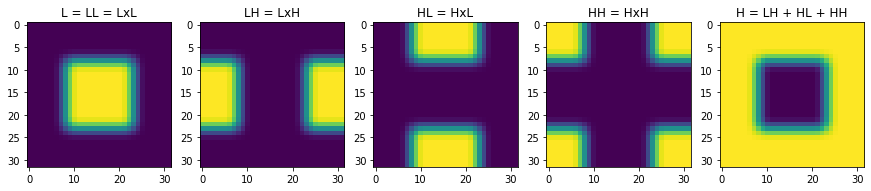

In [ ]:
lp_filt_2d = torch.real(torch.outer(lp2(size,torch.pi/3,2*torch.pi/3),lp2(size,torch.pi/3,2*torch.pi/3)))
hp_filt_2d1 = torch.real(torch.outer(lp2(size,torch.pi/3,2*torch.pi/3),hp2(size,torch.pi/3,2*torch.pi/3)))
hp_filt_2d2 = torch.real(torch.outer(hp2(size,torch.pi/3,2*torch.pi/3),lp2(size,torch.pi/3,2*torch.pi/3)))
hp_filt_2d3 = torch.real(torch.outer(hp2(size,torch.pi/3,2*torch.pi/3),hp2(size,torch.pi/3,2*torch.pi/3)))
hp_filt_2d = hp_filt_2d1 + hp_filt_2d2 + hp_filt_2d3

plt.figure(figsize = (15,6))
plt.subplot(151)
plt.imshow(torch.fft.fftshift(lp_filt_2d))
plt.title('L = LL = LxL')
plt.subplot(152)
plt.imshow(torch.fft.fftshift(hp_filt_2d1))
plt.title('LH = LxH')
plt.subplot(153)
plt.imshow(torch.fft.fftshift(hp_filt_2d2))
plt.title('HL = HxL')
plt.subplot(154)
plt.imshow(torch.fft.fftshift(hp_filt_2d3))
plt.title('HH = HxH')
plt.subplot(155)
plt.imshow(torch.fft.fftshift(hp_filt_2d))
plt.title('H = LH + HL + HH')

## Construct and plot fan-shaped filters

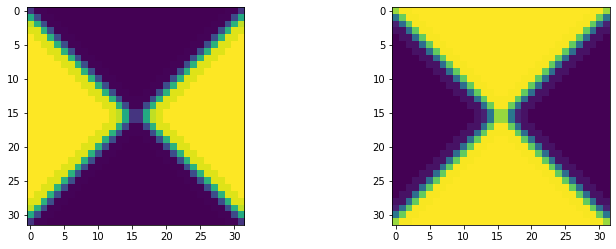

In [ ]:
hp_fan = torch.real(torch.outer(hp2(size,0.707*torch.pi/3,0.707*2*torch.pi/3),hp2(size,0.707*torch.pi/3,0.707*2*torch.pi/3)))

fan1 = torch.roll(torchvision.transforms.functional.rotate(hp_fan.unsqueeze(0),45).squeeze(0),(int(size/2),0), dims=(0,1))
fan2 = 1 - fan1
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(torch.fft.fftshift(fan1))
plt.subplot(122)
plt.imshow(torch.fft.fftshift(fan2))

## Construct Level 0 checkerboard filters using LL filter

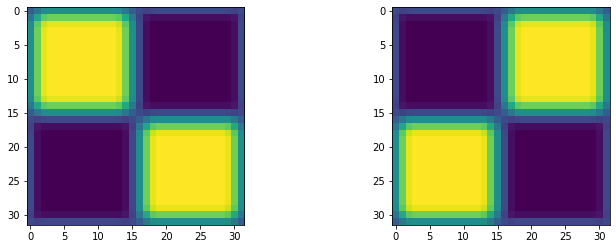

In [ ]:
cb1 = torch.roll(lp_filt_2d, (int(size/4),int(size/4)), dims=(0,1)) + torch.roll(lp_filt_2d, (-int(size/4),-int(size/4)), dims=(0,1))
cb2 = torch.roll(lp_filt_2d, (int(size/4),-int(size/4)), dims=(0,1)) + torch.roll(lp_filt_2d, (-int(size/4),int(size/4)), dims=(0,1))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(torch.fft.fftshift(cb1))
plt.subplot(122)
plt.imshow(torch.fft.fftshift(cb2))

## Construct contourlet filters

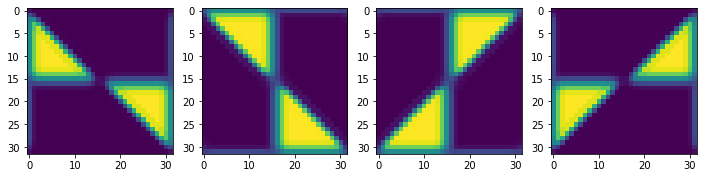

In [ ]:
ct1 = cb1*fan1
ct2 = cb1*fan2
ct3 = cb2*fan2
ct4 = cb2*fan1

plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(torch.fft.fftshift(ct1))
plt.subplot(142)
plt.imshow(torch.fft.fftshift(ct2))
plt.subplot(143)
plt.imshow(torch.fft.fftshift(ct3))
plt.subplot(144)
plt.imshow(torch.fft.fftshift(ct4))

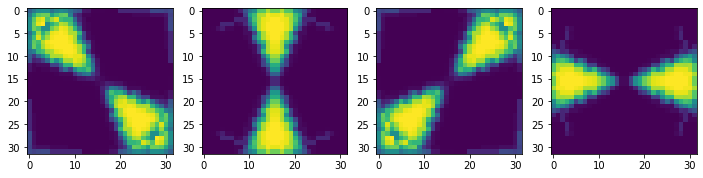

In [ ]:
up1 = torch.roll(torchvision.transforms.functional.rotate((ct1).unsqueeze(0),-22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
up2 = torch.roll(torchvision.transforms.functional.rotate((ct2).unsqueeze(0),-45-22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
up3 = torch.roll(torchvision.transforms.functional.rotate((ct3).unsqueeze(0),45+22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
up4 = torch.roll(torchvision.transforms.functional.rotate((ct4).unsqueeze(0),22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
up = fan2*(up1+up2+up3+up4)/4

side1 = torch.roll(torchvision.transforms.functional.rotate((ct1).unsqueeze(0),45+22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
side2 = torch.roll(torchvision.transforms.functional.rotate((ct2).unsqueeze(0),22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
side3 = torch.roll(torchvision.transforms.functional.rotate((ct3).unsqueeze(0),-22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
side4 = torch.roll(torchvision.transforms.functional.rotate((ct4).unsqueeze(0),-45-22.5,fill=[0.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
side = fan1*(side1+side2+side3+side4)/4

diag11 = torch.roll(torchvision.transforms.functional.rotate((ct1).unsqueeze(0),22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag12 = torch.roll(torchvision.transforms.functional.rotate((ct2).unsqueeze(0),-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag13 = torch.roll(torchvision.transforms.functional.rotate((ct3).unsqueeze(0),-45-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag14 = torch.roll(torchvision.transforms.functional.rotate((ct4).unsqueeze(0),90-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag1 = cb1*(diag11+diag12+diag13+diag14)/4

diag21 = torch.roll(torchvision.transforms.functional.rotate((ct1).unsqueeze(0),-45-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag22 = torch.roll(torchvision.transforms.functional.rotate((ct2).unsqueeze(0),90-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag23 = torch.roll(torchvision.transforms.functional.rotate((ct3).unsqueeze(0),22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag24 = torch.roll(torchvision.transforms.functional.rotate((ct4).unsqueeze(0),-22.5,fill=[1.]).squeeze(0), (int(size/2),int(size/2)),dims=(0,1))
diag2 = cb2*(diag21+diag22+diag23+diag24)/4

plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(torch.fft.fftshift(diag1))
plt.subplot(142)
plt.imshow(torch.fft.fftshift(up))
plt.subplot(143)
plt.imshow(torch.fft.fftshift(diag2))
plt.subplot(144)
plt.imshow(torch.fft.fftshift(side))

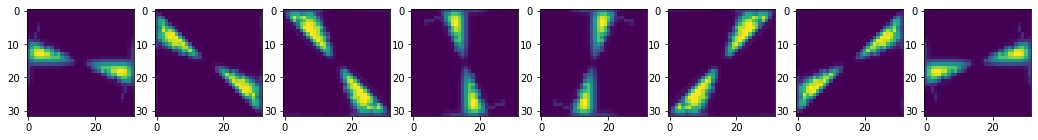

In [ ]:
ctdf1 = ct1*side
ctdf2 = ct1*diag1
ctdf3 = ct2*diag1
ctdf4 = ct2*up
ctdf5 = ct3*up
ctdf6 = ct3*diag2
ctdf7 = ct4*diag2
ctdf8 = ct4*side
ctdfs = [ctdf1,ctdf2,ctdf3,ctdf4,ctdf5,ctdf6,ctdf7,ctdf8]

plt.figure(figsize=(18,6))
plt.subplot(181)
plt.imshow(torch.fft.fftshift(ctdf1))
plt.subplot(182)
plt.imshow(torch.fft.fftshift(ctdf2))
plt.subplot(183)
plt.imshow(torch.fft.fftshift(ctdf3))
plt.subplot(184)
plt.imshow(torch.fft.fftshift(ctdf4))
plt.subplot(185)
plt.imshow(torch.fft.fftshift(ctdf5))
plt.subplot(186)
plt.imshow(torch.fft.fftshift(ctdf6))
plt.subplot(187)
plt.imshow(torch.fft.fftshift(ctdf7))
plt.subplot(188)
plt.imshow(torch.fft.fftshift(ctdf8))

## Outputs for contourlet filters

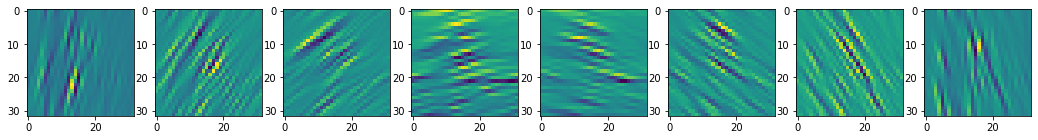

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(181)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf1)))
plt.subplot(182)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf2)))
plt.subplot(183)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf3)))
plt.subplot(184)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf4)))
plt.subplot(185)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf5)))
plt.subplot(186)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf6)))
plt.subplot(187)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf7)))
plt.subplot(188)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*ctdf8)))

## Construct Level 0 directional filters

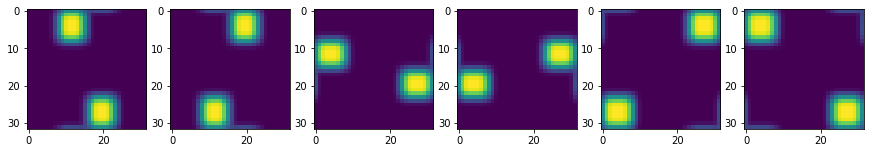

In [ ]:
df1 = hp_filt_2d2 * cb1 
df2 = hp_filt_2d2 * cb2
df3 = hp_filt_2d1 * cb1 
df4 = hp_filt_2d1 * cb2
df5 = hp_filt_2d3 * cb2 
df6 = hp_filt_2d3 * cb1
dfs = [df1,df2,df3,df4,df5,df6]

plt.figure(figsize=(15,6))
plt.subplot(161)
plt.imshow(torch.fft.fftshift(df1))
plt.subplot(162)
plt.imshow(torch.fft.fftshift(df2))
plt.subplot(163)
plt.imshow(torch.fft.fftshift(df3))
plt.subplot(164)
plt.imshow(torch.fft.fftshift(df4))
plt.subplot(165)
plt.imshow(torch.fft.fftshift(df5))
plt.subplot(166)
plt.imshow(torch.fft.fftshift(df6))

## Construct and plot Level 1 2-D filters

Text(0.5, 1.0, 'H = LH + HL + HH')

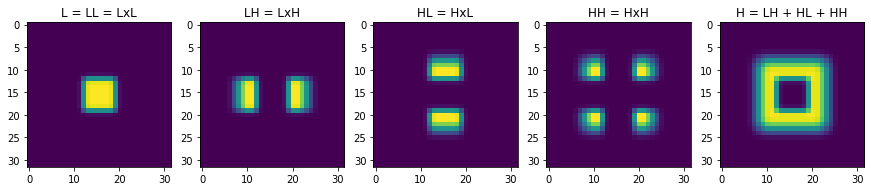

In [ ]:
l1_lp_filt_2d = lp_filt_2d * torch.real(torch.outer(lp2(size,torch.pi/6,torch.pi/3),lp2(size,torch.pi/6,torch.pi/3)))
l1_hp_filt_2d1 = lp_filt_2d * torch.real(torch.outer(lp2(size,torch.pi/6,torch.pi/3),hp2(size,torch.pi/6,torch.pi/3)))
l1_hp_filt_2d2 = lp_filt_2d * torch.real(torch.outer(hp2(size,torch.pi/6,torch.pi/3),lp2(size,torch.pi/6,torch.pi/3)))
l1_hp_filt_2d3 = lp_filt_2d * torch.real(torch.outer(hp2(size,torch.pi/6,torch.pi/3),hp2(size,torch.pi/6,torch.pi/3)))
l1_hp_filt_2d = l1_hp_filt_2d1 + l1_hp_filt_2d2 + l1_hp_filt_2d3

plt.figure(figsize = (15,6))
plt.subplot(151)
plt.imshow(torch.fft.fftshift(l1_lp_filt_2d))
plt.title('L = LL = LxL')
plt.subplot(152)
plt.imshow(torch.fft.fftshift(l1_hp_filt_2d1))
plt.title('LH = LxH')
plt.subplot(153)
plt.imshow(torch.fft.fftshift(l1_hp_filt_2d2))
plt.title('HL = HxL')
plt.subplot(154)
plt.imshow(torch.fft.fftshift(l1_hp_filt_2d3))
plt.title('HH = HxH')
plt.subplot(155)
plt.imshow(torch.fft.fftshift(l1_hp_filt_2d))
plt.title('H = LH + HL + HH')

## Construct Level 1 checkerboard filters using LL filter

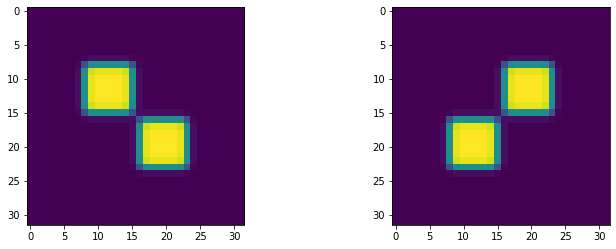

In [ ]:
l1_cb1 = torch.roll(l1_lp_filt_2d, (int(size/8),int(size/8)), dims=(0,1)) + torch.roll(l1_lp_filt_2d, (-int(size/8),-int(size/8)), dims=(0,1))
l1_cb2 = torch.roll(l1_lp_filt_2d, (int(size/8),-int(size/8)), dims=(0,1)) + torch.roll(l1_lp_filt_2d, (-int(size/8),int(size/8)), dims=(0,1))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(torch.fft.fftshift(l1_cb1))
plt.subplot(122)
plt.imshow(torch.fft.fftshift(l1_cb2))

## Construct Level 1 directional filters

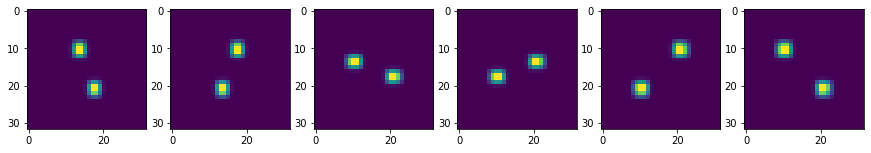

In [ ]:
l1_df1 = l1_hp_filt_2d2 * l1_cb1 
l1_df2 = l1_hp_filt_2d2 * l1_cb2
l1_df3 = l1_hp_filt_2d1 * l1_cb1 
l1_df4 = l1_hp_filt_2d1 * l1_cb2
l1_df5 = l1_hp_filt_2d3 * l1_cb2 
l1_df6 = l1_hp_filt_2d3 * l1_cb1
l1_dfs = [l1_df1,l1_df2,l1_df3,l1_df4,l1_df5,l1_df6]

plt.figure(figsize=(15,6))
plt.subplot(161)
plt.imshow(torch.fft.fftshift(l1_df1))
plt.subplot(162)
plt.imshow(torch.fft.fftshift(l1_df2))
plt.subplot(163)
plt.imshow(torch.fft.fftshift(l1_df3))
plt.subplot(164)
plt.imshow(torch.fft.fftshift(l1_df4))
plt.subplot(165)
plt.imshow(torch.fft.fftshift(l1_df5))
plt.subplot(166)
plt.imshow(torch.fft.fftshift(l1_df6))

## Define Scaling filter

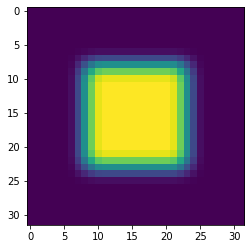

In [ ]:
scaling = lp_filt_2d
plt.imshow(torch.fft.fftshift(scaling))

## Outputs for Level 0 directional filters

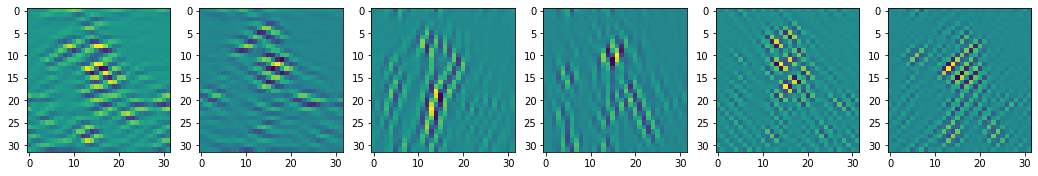

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(161)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df1)))
plt.subplot(162)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df2)))
plt.subplot(163)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df3)))
plt.subplot(164)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df4)))
plt.subplot(165)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df5)))
plt.subplot(166)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*df6)))

## Outputs for Level 1 directional filter

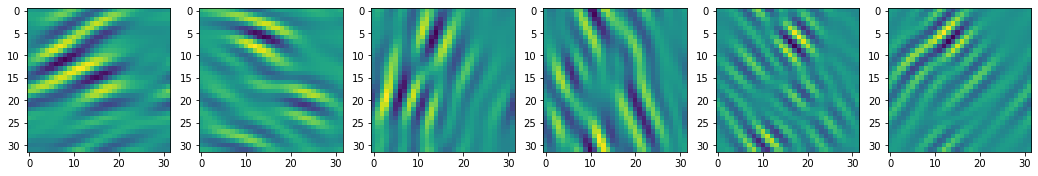

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(161)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df1)))
plt.subplot(162)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df2)))
plt.subplot(163)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df3)))
plt.subplot(164)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df4)))
plt.subplot(165)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df5)))
plt.subplot(166)
plt.imshow(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_df6)))

## Zeroth Order Scattering Coefficients

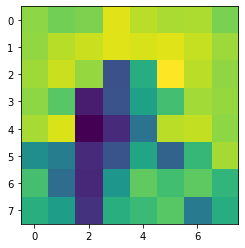

In [ ]:
S_0 = torch.real(torch.fft.ifft2(torch.fft.fft2(image)*scaling))
S_0 = torch.nn.functional.conv2d(S_0.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
plt.imshow(S_0)

## 1st Order Scattering Coefficients

### Gabor

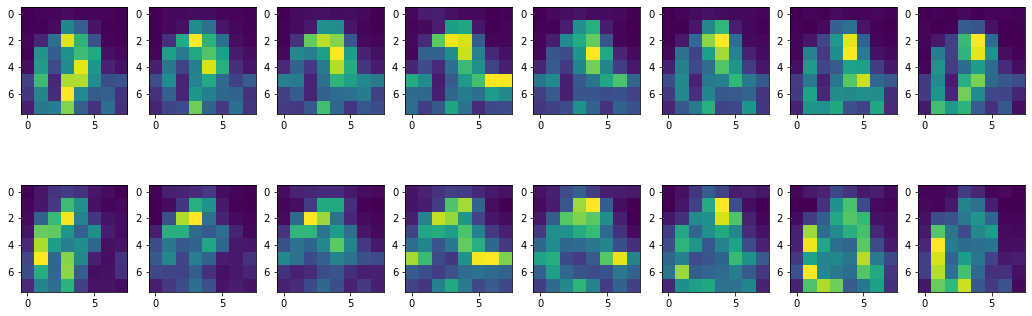

In [ ]:
S_1 = Scattering2D(J=2, shape=(size,size))(image)[1:17]
plt.figure(figsize=(18,6))
for i in range(len(S_1)):
  plt.subplot(2,8,i+1)
  plt.imshow(S_1[i])

### Contourlet

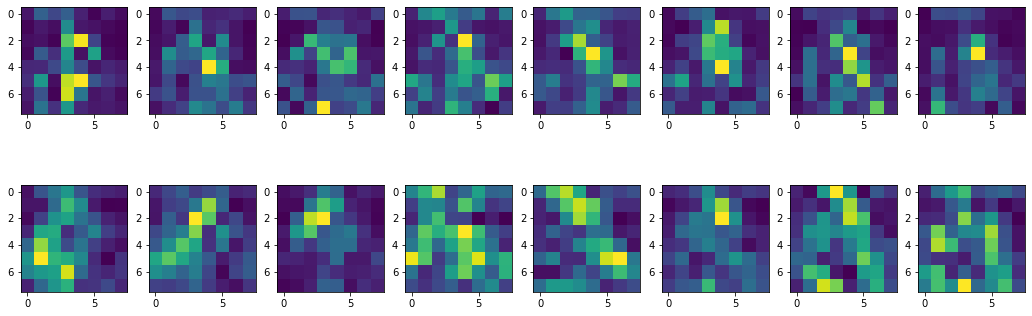

In [ ]:
S_1 = []

for ctdf in ctdfs:
  temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d*ctdf)))
  temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
  temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
  S_1.append(temp)

for ctdf1 in ctdfs:
  temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_hp_filt_2d*ctdf1)))
  temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
  temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
  S_1.append(temp)

plt.figure(figsize=(18,6))
for i in range(len(S_1)):
  plt.subplot(2,8,i+1)
  plt.imshow(S_1[i])

### Checkerboard

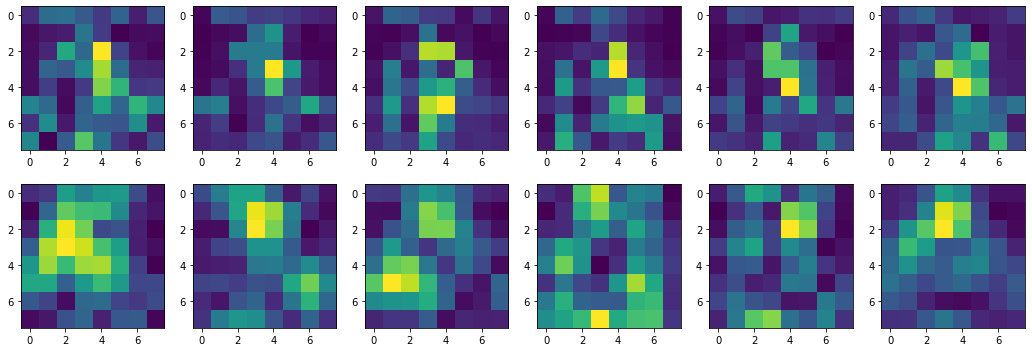

In [ ]:
S_1 = []

for df in dfs:
  temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d*df)))
  temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
  temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
  S_1.append(temp)

for l1_df in l1_dfs:
  temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_hp_filt_2d*l1_df)))
  temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
  temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
  S_1.append(temp)

plt.figure(figsize=(18,6))
for i in range(len(S_1)):
  plt.subplot(2,6,i+1)
  plt.imshow(S_1[i])

## 2nd Order Scattering Coefficients

### Gabor

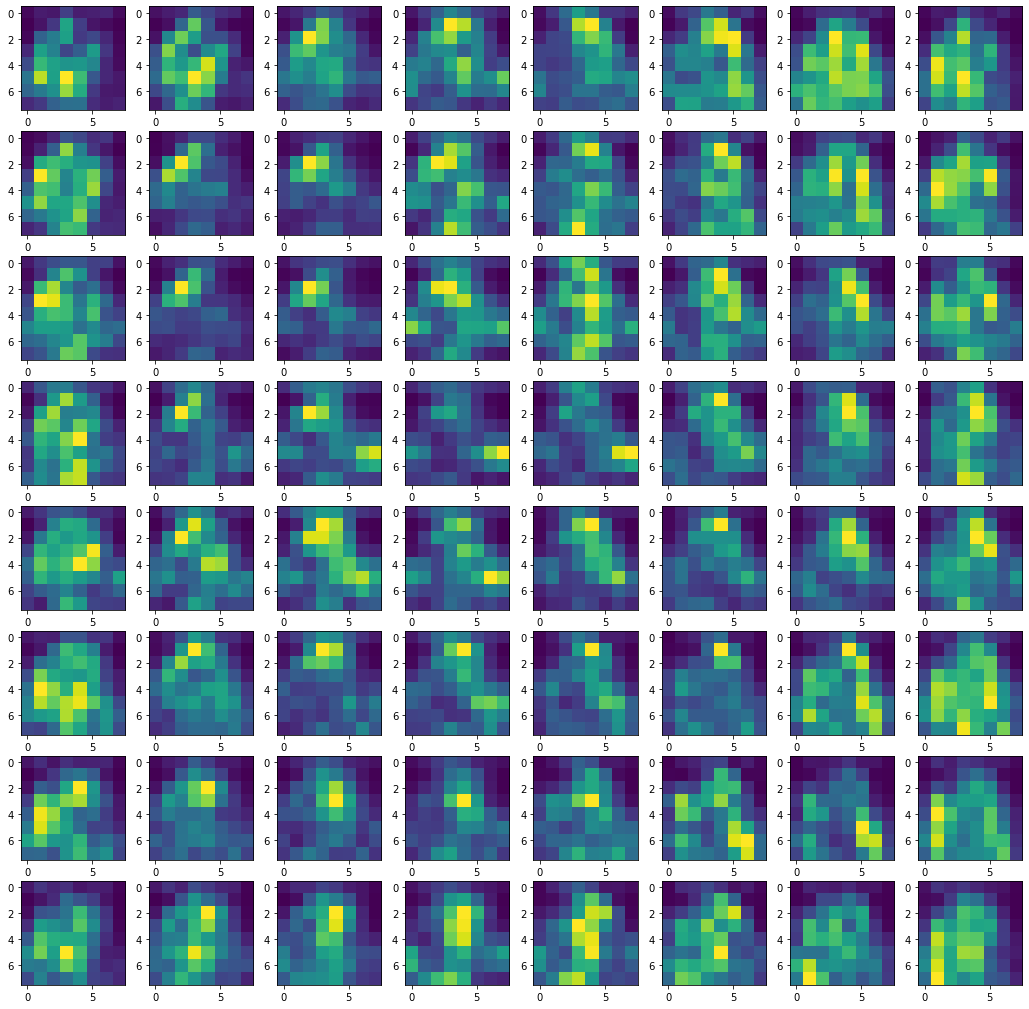

In [ ]:
S_2 = Scattering2D(J=2, shape=(size,size))(image)[17:]
plt.figure(figsize=(18,18))
for i in range(len(S_2)):
  plt.subplot(8,8,i+1)
  plt.imshow(S_2[i])

### Contourlet

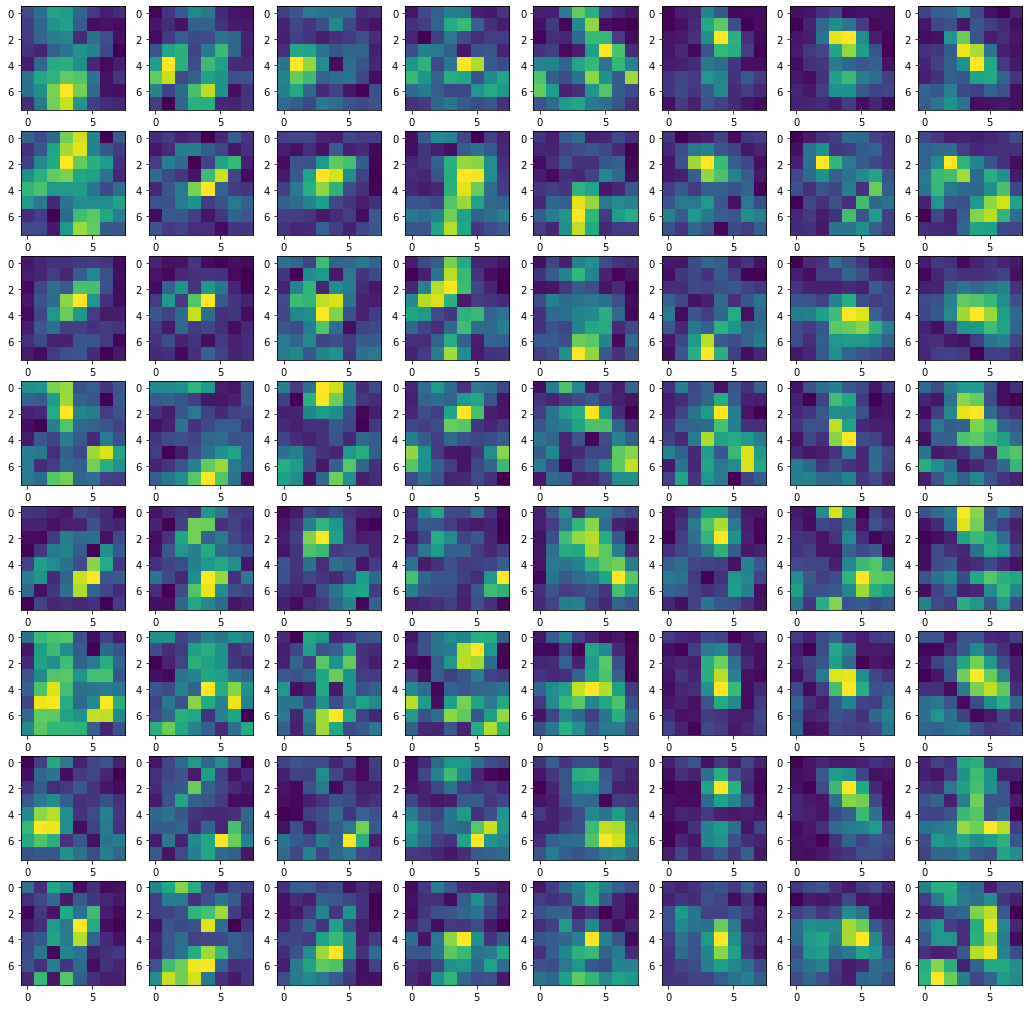

In [ ]:
S_2 = []

for ctdf in ctdfs:
  for ctdf1 in ctdfs:
    temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d*ctdf))))*l1_hp_filt_2d*ctdf1)))
    temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
    temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
    S_2.append(temp)

plt.figure(figsize=(18,18))
for i in range(len(S_2)):
  plt.subplot(8,8,i+1)
  plt.imshow(S_2[i])

### Checkerboard

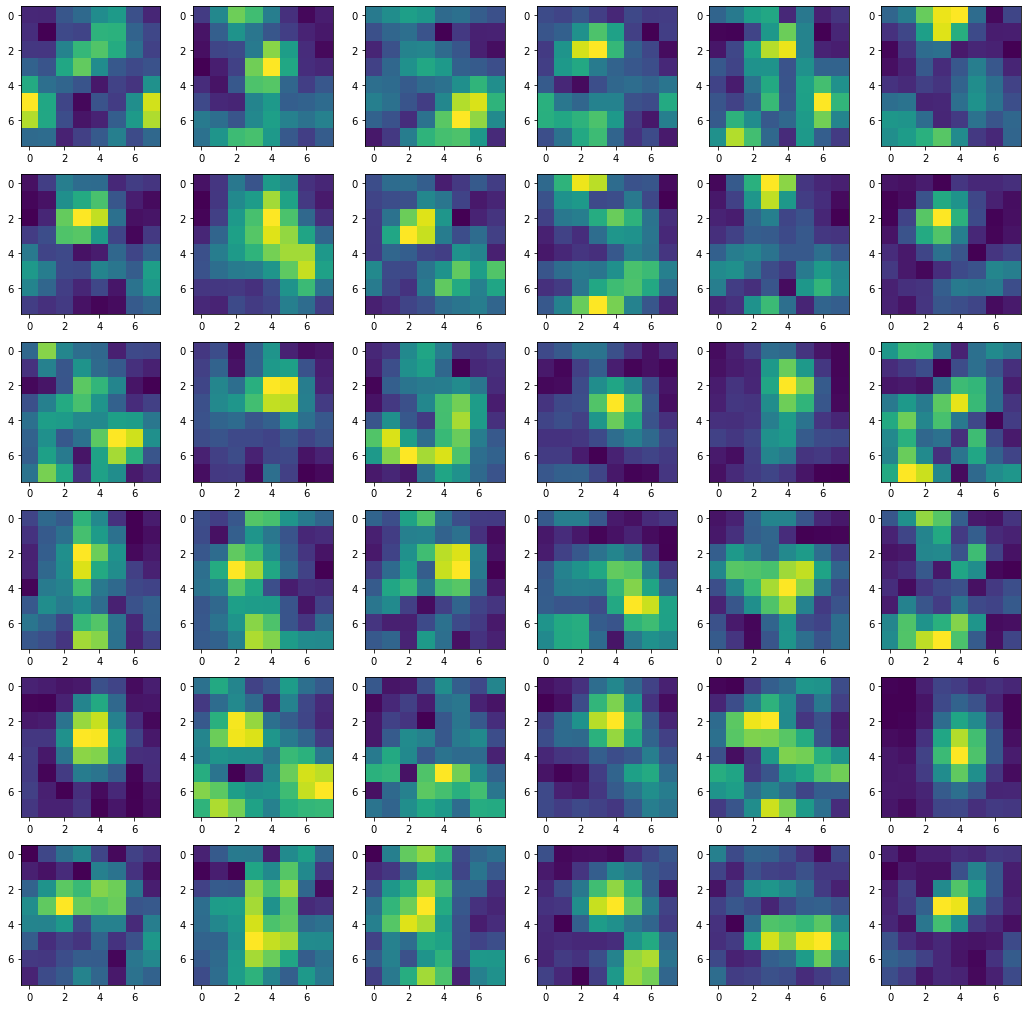

In [ ]:
S_2 = []

for df in dfs:
  for l1_df in l1_dfs:
    temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d*df))))*l1_hp_filt_2d*l1_df)))
    temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
    temp = torch.nn.functional.conv2d(temp.unsqueeze(0).unsqueeze(0), torch.tensor([[[[1.]]]]), stride=4).squeeze(0).squeeze(0)
    S_2.append(temp)

plt.figure(figsize=(18,18))
for i in range(len(S_2)):
  plt.subplot(6,6,i+1)
  plt.imshow(S_2[i])

## Define a function for Scattering on device

In [ ]:
scattering_gabor = Scattering2D(J=2, shape=(size, size))
scattering_gabor.to(device)

Scattering2D()

In [ ]:
def scattering_contourlet(image, dfs=torch.stack(ctdfs).to(device), l1_dfs=torch.stack(ctdfs).to(device), scaling=scaling.to(device), max_order=2):
      S_0 = torch.real(torch.fft.ifft2(torch.fft.fft2(image)*scaling))
      S_0 = torch.nn.functional.conv2d(S_0, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)

      S_1 = []
      for df in dfs:
        temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d.to(device)*df)))
        temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
        temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
        S_1.append(temp)

      for l1_df in l1_dfs:
        temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_hp_filt_2d.to(device)*l1_df)))
        temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
        temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
        S_1.append(temp)

      S_2 = []

      for df in dfs:
        for l1_df in l1_dfs:
          temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d.to(device)*df))))*l1_hp_filt_2d.to(device)*l1_df)))
          temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
          temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
          S_2.append(temp)

      if max_order == 0:
        return torch.swapaxes(S_0.unsqueeze(0),0,1)
      elif max_order == 1:
        return torch.swapaxes(torch.concat([S_0.unsqueeze(0), torch.stack(S_1)]),0,1)
      return torch.swapaxes(torch.concat([S_0.unsqueeze(0), torch.stack(S_1), torch.stack(S_2)]),0,1)

In [ ]:
def scattering_checkerboard(image, dfs=torch.stack(dfs).to(device), l1_dfs=torch.stack(l1_dfs).to(device), scaling=scaling.to(device), max_order=2):
      S_0 = torch.real(torch.fft.ifft2(torch.fft.fft2(image)*scaling))
      S_0 = torch.nn.functional.conv2d(S_0, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)

      S_1 = []
      for df in dfs:
        temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d.to(device)*df)))
        temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
        temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
        S_1.append(temp)

      for l1_df in l1_dfs:
        temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*l1_hp_filt_2d.to(device)*l1_df)))
        temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
        temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
        S_1.append(temp)

      S_2 = []

      for df in dfs:
        for l1_df in l1_dfs:
          temp = torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(torch.abs(torch.real(torch.fft.ifft2(torch.fft.fft2(image)*hp_filt_2d.to(device)*df))))*l1_hp_filt_2d.to(device)*l1_df)))
          temp = torch.real(torch.fft.ifft2(torch.fft.fft2(temp)*scaling))
          temp = torch.nn.functional.conv2d(temp, torch.tensor([[[[1.]]],[[[1.]]],[[[1.]]]]).to(device), stride=4, groups=3)
          S_2.append(temp)

      if max_order == 0:
        return torch.swapaxes(S_0.unsqueeze(0),0,1)
      elif max_order == 1:
        return torch.swapaxes(torch.concat([S_0.unsqueeze(0), torch.stack(S_1)]),0,1)
      return torch.swapaxes(torch.concat([S_0.unsqueeze(0), torch.stack(S_1), torch.stack(S_2)]),0,1)

## Define and train model 

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = x.reshape(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



def train(model, device, train_loader, optimizer, epoch, scattering):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(scattering(data, max_order=0))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, scattering):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(scattering(data, max_order=0))
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

mode = 0
width = 4

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if mode == 0:
    K = 1*3
elif mode == 1:
    K = 13*3
else:
    K = 49*3
#scattering = Scattering().to(device)


model = Scattering2dResNet(K, width).to(device)

num_workers = 4
if use_cuda:
    pin_memory = True
else:
    pin_memory = False

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    # Optimizer
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
best_test_accuracy = 0
for epoch in range(0, 200):
    if epoch in [60, 120, 160]:
        lr *= 0.2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    train(model, device, train_loader, optimizer, epoch+1, scattering)
    test_accuracy = test(model, device, test_loader, scattering)
    if test_accuracy > best_test_accuracy:
            torch.save(model,'/content/drive/My Drive/Impulse/best_model_level_0_scattering.pth')
            best_test_accuracy = test_accuracy
            print('Saving best model')

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.478233
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.347057
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.187632
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.112089
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.045810
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.021590
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.018976
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.076206

Test set: Average loss: 1.9560, Accuracy: 2677/10000 (26.77%)

Saving best model
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.926733
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.970118
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.832688
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.769229
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.628819
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.894946
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.853815
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.747495

Test set: Average loss: 1.6981, Accuracy: 3766/10000 (37.66%)

Saving best model
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.838997
Tra

## Testing the model

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = torch.jit.load('/content/drive/My Drive/Impulse Hackathon/level_2_scattering_jit.pth')
device = 'cuda'
num_workers = 4
pin_memory = True

def test(model, device, test_loader, scattering):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(scattering(data, max_order=2))
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

test_accuracy = test(model, device, test_loader, scattering_checkerboard)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Test set: Average loss: 0.7735, Accuracy: 8511/10000 (85.11%)



In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = x.reshape(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
from torchsummary import summary
mode = 2
width = 32

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if mode == 0:
    K = 1*3
elif mode == 1:
    K = 13*3
else:
    K = 49*3
model = Scattering2dResNet(K, width).to(device)
summary(model,(147,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 147, 8, 8]               0
            Conv2d-2            [-1, 512, 8, 8]         677,376
       BatchNorm2d-3            [-1, 512, 8, 8]           1,024
              ReLU-4            [-1, 512, 8, 8]               0
            Conv2d-5           [-1, 1024, 8, 8]       4,718,592
       BatchNorm2d-6           [-1, 1024, 8, 8]           2,048
              ReLU-7           [-1, 1024, 8, 8]               0
            Conv2d-8           [-1, 1024, 8, 8]       9,437,184
       BatchNorm2d-9           [-1, 1024, 8, 8]           2,048
           Conv2d-10           [-1, 1024, 8, 8]         524,288
      BatchNorm2d-11           [-1, 1024, 8, 8]           2,048
             ReLU-12           [-1, 1024, 8, 8]               0
       BasicBlock-13           [-1, 1024, 8, 8]               0
           Conv2d-14           [-1, 102

In [ ]:
# Level 0 size=[128,1,3,8,8]
# Level 1 size=[128,13,3,8,8]
# Level 2 size=[128,49,3,8,8]
#model = torch.load('/content/drive/My Drive/Impulse/best_model_level_2_scattering.pth')
#trace = torch.jit.trace(model, torch.ones(size=[128,49,3,8,8]).cuda())
#torch.jit.save(trace, '/content/drive/My Drive/Impulse/best_model_level_2_scattering_jit.pth')